In [4]:
%pip install pyodbc

     ---------------------------------------- 68.9/68.9 kB 1.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [97]:
# 1. Libraries and local variable
import pyodbc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import random

from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# 2. Fetching
# Define your connection string to the SQL Server
server = 'PC';
database = '2425.BI.DATH_NDS';

# Create the connection string
conn_str = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes;';

# Establish the connection
conn = pyodbc.connect(conn_str);

# Define your SQL query
sql_query =   'exec str_mining_air_quality_fetch';

# Use pandas to read the SQL query into a DataFrame
data = pd.read_sql(sql_query, conn);

# Close the connection
conn.close();

# Display the DataFrame
print(data);


C:\Users\phamg\AppData\Local\Temp\ipykernel_21488\1725520421.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(sql_query, conn);


              date     county        category
0       2021-09-29     Fresno        Moderate
1       2021-09-30     Fresno        Moderate
2       2021-10-01     Fresno       Unhealthy
3       2021-10-02     Fresno       Unhealthy
4       2021-10-03     Fresno  Very Unhealthy
...            ...        ...             ...
187928  2023-11-21  El Dorado            Good
187929  2023-11-22  El Dorado            Good
187930  2023-11-23  El Dorado            Good
187931  2023-11-24  El Dorado            Good
187932  2023-11-25  El Dorado            Good

[187933 rows x 3 columns]


In [89]:
# 3. Category numeric mappings
# Define the mapping dictionary
category_mapping = {
    'Good': 6,
    'Moderate': 5,
    'Hazardous': 4,
    'Unhealthy': 3,
    'Unhealthy for Sensitive Groups': 2,
    'Very Unhealthy': 1
};
category = ['Good',
    'Moderate',
    'Hazardous',
    'Unhealthy',
    'Unhealthy for Sensitive Groups',
    'Very Unhealthy'
];

# Assuming you have a column in the DataFrame with these status values (e.g., 'status')
# You can use the pandas `.map()` method to replace the string values with the corresponding numbers
data['category_numeric'] = data['category'].map(category_mapping);
print(data);

              date     county        category  category_numeric
0       2021-09-29     Fresno        Moderate                 5
1       2021-09-30     Fresno        Moderate                 5
2       2021-10-01     Fresno       Unhealthy                 3
3       2021-10-02     Fresno       Unhealthy                 3
4       2021-10-03     Fresno  Very Unhealthy                 1
...            ...        ...             ...               ...
187928  2023-11-21  El Dorado            Good                 6
187929  2023-11-22  El Dorado            Good                 6
187930  2023-11-23  El Dorado            Good                 6
187931  2023-11-24  El Dorado            Good                 6
187932  2023-11-25  El Dorado            Good                 6

[187933 rows x 4 columns]


C:\Users\phamg\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\phamg\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



RMSE: 0.8454988576110585, MAE: 0.583817073174801


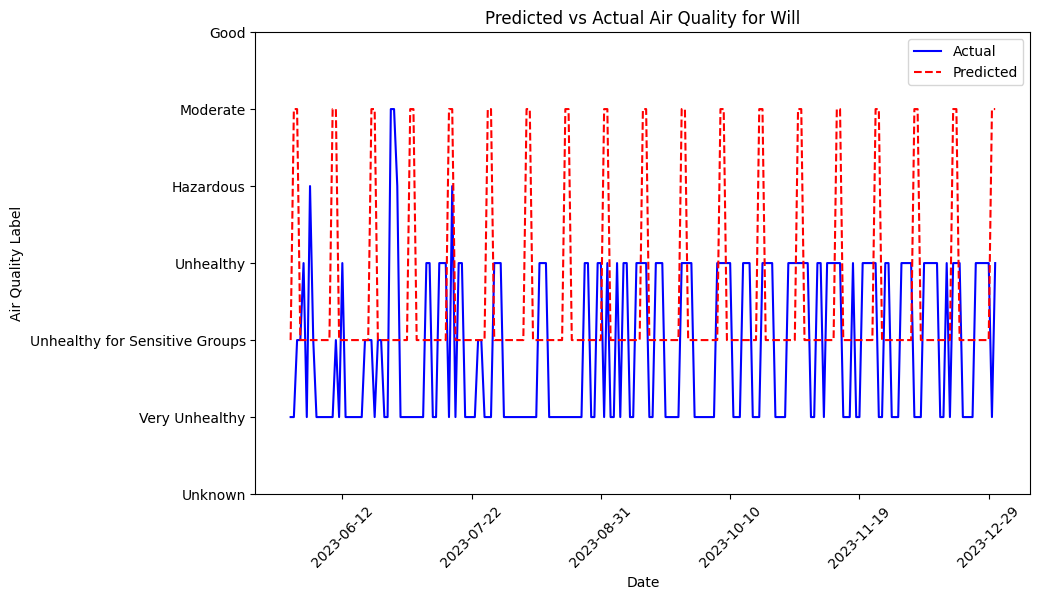

In [95]:
# 4. Evaluation
county = 'Will';

# Filter data by geography
location_data = data[data['county'].str.strip() == county];

# Set date as index and sort
location_data.set_index('date', inplace=True);
location_data = location_data.sort_index();

# Split the data into train and test sets
train_size = int(len(location_data) * 0.8);  # 80% for training
train_data, test_data = location_data[:train_size], location_data[train_size:];

# Train SARIMA model on the training set
#Define possible values for p, d, q, P, D, Q, S
# p_values = [0, 1, 2];# AR
# d_values = [0, 1];     # Differencing
# q_values = [0, 1, 2];  # MA

# seasonal_order = [(0, 1, 1, 12), (1, 1, 1, 12), (0, 1, 2, 12)];

model = SARIMAX(train_data['category_numeric'], order=(0, 0, 0), seasonal_order=(0,1,1,12));
model.initialize_approximate_diffuse()
fitted = model.fit()

# Predict on the test set
forecast = fitted.get_forecast(steps=len(test_data));
forecast_mean = forecast.predicted_mean;
category_numeric = [int(round(num, 0)) for num in forecast_mean];
ctg = [category[category_numeric[idx] - 1] for idx in range(len(category_numeric))];

# Create a DataFrame for the predicted values
test_dates = test_data.index;
df_pred = pd.DataFrame({
    "Date": test_dates,
    "Actual": test_data['category'],
    "Predicted": ctg
});

# Residuals and error metrics
residuals = fitted.resid;
rmse = np.sqrt(np.mean(residuals**2));
mae = np.mean(np.abs(residuals));
print(f"\nRMSE: {rmse}, MAE: {mae}");

# Visualize predicted vs actual
plt.figure(figsize=(10, 6));
plt.plot(df_pred['Date'], df_pred['Actual'], label='Actual', color='blue');
plt.plot(df_pred['Date'], df_pred['Predicted'], label='Predicted', color='red', linestyle='dashed');
plt.xlabel('Date');
plt.ylabel('Air Quality Label');
plt.title(f'Predicted vs Actual Air Quality for {county}');
plt.legend();

# Reduce the number of x-ticks (date labels) by using MaxNLocator
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=7))  # Show a max of 6 ticks
# Get the current x-tick positions and label them with the corresponding dates
plt.xticks(rotation=45);

# Get current y-tick positions and labels
# Set y-axis to have a maximum of 5 ticks
ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5));

# Get current y-tick positions (actual number of ticks)
category_map = {6 - i: c for i, c in enumerate(category)};
y_tick_positions = ax.get_yticks();

# If you have more ticks than the desired number, slice the ticks array
# Here, we limit to only 5 y-tick positions
if len(y_tick_positions) > 5:
    y_tick_positions = y_tick_positions[::len(y_tick_positions) // 5];  # Pick evenly spaced ticks

# Set the y-ticks with the correct number of labels
y_tick_labels = [];
plt.yticks(ticks=y_tick_positions, labels=y_tick_labels);
for tick in y_tick_positions:
    if tick == -1:  # Explicitly keep 0 as '0'
        y_tick_labels.append('Unknown');
    else:
        # Map the numeric tick position to categories, clip it to the valid range
        clipped_tick = int(np.clip(tick, 0, len(category)-1));
        y_tick_labels.append(category_map.get(clipped_tick + 1, 'Unknown'));
# Set the y-ticks with the correct category labels
plt.yticks(ticks=y_tick_positions, labels=y_tick_labels);

plt.show();





In [103]:
# Extract column  as a numpy array
arr = data['county'].values.tolist();  # Using .values

suggest = random.sample(arr, 5);

print(f"Suggestion county names: ", suggest);

Suggestion county names:  ['McLean', 'Knox', 'Oliver', 'Hood', 'Hidalgo']


In [110]:
# 5. Predict

query_county = 'Oliver'
future_date = '2025-05-10'

# Filter data by geography
location_data = data[data['county'].str.strip() == query_county];

location_data.set_index('date', inplace=True)
location_data = location_data.sort_index();

#print(data[data['geography'].str.strip() == 'Washington']);
lastDate = location_data.index[-1];
date1 = lastDate;
date2 = datetime.strptime(future_date, '%Y-%m-%d').date();
dateDiff = date2 - date1;
steps = dateDiff.days;

# Train SARIMA model
model = SARIMAX(location_data['category_numeric'], order=(1, 0, 0), seasonal_order=(0,1,1,12));
model.initialize_approximate_diffuse();
fitted = model.fit();

# Predict future label
forecast = fitted.get_forecast(steps);
forecast_mean = forecast.predicted_mean;
result = forecast_mean.tail(1).values[0];
result = round(result);
print(f"Forecast air quality for county {query_county} on {future_date}:", category[6 - result]);

C:\Users\phamg\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\phamg\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Forecast air quality for county Oliver on 2025-05-10: Good
